In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# General functions to run

Active learning Pipeline

# Datasets Evaluation

## IMDB Dataset

the dataset can be found here: https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews?resource=download

### First Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [ ]:
# Ensure nltk resources are downloaded
nltk.download('stopwords')

# Load the dataset
imdb_data = pd.read_csv('../data/IMDB Dataset.csv')

# Sentiment Distribution
def sentiment_distribution(data):
    sentiment_counts = data['sentiment'].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Text Analysis
def text_analysis(data):
    # Review Length Distribution
    data['review_length'] = data['review'].apply(len)
    plt.figure(figsize=(8, 6))
    sns.histplot(data['review_length'], kde=True, color='blue')
    plt.title('Review Length Distribution')
    plt.xlabel('Review Length')
    plt.ylabel('Frequency')
    plt.show()

    # Most Common Words
    stop_words = set(stopwords.words('english'))
    words = ' '.join(data['review']).lower().split()
    words = [word for word in words if word.isalpha() and word not in stop_words]
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='inferno')
    plt.title('Most Common Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

    # Word Cloud for Positive and Negative Reviews
    positive_reviews = data[data['sentiment'] == 'positive']['review'].str.cat(sep=' ')
    negative_reviews = data[data['sentiment'] == 'negative']['review'].str.cat(sep=' ')

    wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white', colormap='Blues').generate(positive_reviews)
    wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white', colormap='Reds').generate(negative_reviews)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Word Cloud for Positive Reviews')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Word Cloud for Negative Reviews')
    plt.axis('off')

    plt.show()

# Additional Insights
def additional_insights(data):
    # Average review length by sentiment
    avg_length_by_sentiment = data.groupby('sentiment')['review_length'].mean()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=avg_length_by_sentiment.index, y=avg_length_by_sentiment.values, palette='coolwarm')
    plt.title('Average Review Length by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Review Length')
    plt.show()

In [ ]:
sentiment_distribution(imdb_data)

In [ ]:
text_analysis(imdb_data)

In [ ]:
additional_insights(imdb_data)

### Active learning pipeline

In [27]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

# Load the CSV file
imdb_data = pd.read_csv('../data/IMDB Dataset.csv')

# Encode the target labels
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Separate positive and negative samples
positive_samples = imdb_data[imdb_data['sentiment'] == 1]
negative_samples = imdb_data[imdb_data['sentiment'] == 0]

# Sample half of the negative samples
negative_samples_sampled = negative_samples.sample(frac=0.5, random_state=42)

# Concatenate positive samples with the sampled negative samples
imdb_data = pd.concat([positive_samples, negative_samples_sampled])

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Split data into a pool of unlabeled data and a small initial training set
X_pool, X_initial, y_pool, y_initial = train_test_split(imdb_data['review'], imdb_data['sentiment'], test_size=0.05, random_state=42)

# Vectorize the initial training set
X_initial_vectorized = vectorizer.fit_transform(X_initial).toarray()

# Initialize the model
model = LogisticRegression()

# Train the model on the initial training set
model.fit(X_initial_vectorized, y_initial)

# Define the number of iterations and the sample size for each iteration
iterations = 10
sample_size = 100

# Active Learning Loop
for i in range(iterations):
    # Randomly sample a subset from the pool
    sample_indices = random.sample(range(len(X_pool)), sample_size)
    X_sampled = X_pool.iloc[sample_indices]
    y_sampled = y_pool.iloc[sample_indices]

    # Vectorize the sampled data
    X_sampled_vectorized = vectorizer.transform(X_sampled).toarray()

    # Update the training data
    X_initial_vectorized = np.vstack((X_initial_vectorized, X_sampled_vectorized))
    y_initial = np.hstack((y_initial, y_sampled))

    # Shuffle the updated training data
    X_initial_vectorized, y_initial = shuffle(X_initial_vectorized, y_initial, random_state=42)

    # Retrain the model on the updated training set
    model.fit(X_initial_vectorized, y_initial)

    # Evaluate the model on a test set
    X_test_vectorized = vectorizer.transform(imdb_data['review']).toarray()
    y_test = imdb_data['sentiment']
    y_pred = model.predict(X_test_vectorized)

    # Output the current iteration's performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Iteration {i+1}/{iterations} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Remove the sampled instances from the pool
    X_pool = X_pool.drop(X_sampled.index)
    y_pool = y_pool.drop(y_sampled.index)

    # Check if the pool is empty
    if len(X_pool) == 0:
        print("No more data to sample from.")
        break

Iteration 1/10 - Accuracy: 0.8170
              precision    recall  f1-score   support

           0       0.93      0.49      0.64     12500
           1       0.79      0.98      0.88     25000

    accuracy                           0.82     37500
   macro avg       0.86      0.74      0.76     37500
weighted avg       0.84      0.82      0.80     37500

Iteration 2/10 - Accuracy: 0.8203
              precision    recall  f1-score   support

           0       0.93      0.50      0.65     12500
           1       0.80      0.98      0.88     25000

    accuracy                           0.82     37500
   macro avg       0.86      0.74      0.76     37500
weighted avg       0.84      0.82      0.80     37500

Iteration 3/10 - Accuracy: 0.8228
              precision    recall  f1-score   support

           0       0.93      0.51      0.66     12500
           1       0.80      0.98      0.88     25000

    accuracy                           0.82     37500
   macro avg       0.86   

## IMDB gener classification for descriptions

The dataset have been taken from: https://www.kaggle.com/datasets/thedevastator/imdb-movie-and-crew-data

### First Analysis

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
# Ensure nltk resources are downloaded
nltk.download('stopwords')
# Download the 'punkt' resource
nltk.download('punkt')

imdb_movies_data = pd.read_csv('../data/IMDb movies.csv')

# Preprocess the genre column
def preprocess_genre(genre_str):
    if pd.isna(genre_str):
        return []
    return [genre.strip() for genre in genre_str.split(',')]

imdb_movies_data['genre'] = imdb_movies_data['genre'].apply(preprocess_genre)

# Display the first few rows to understand the structure
# print(imdb_movies_data.head(5))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yarden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yarden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Check for missing values
missing_values = imdb_movies_data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")


Missing values in each column:
index                        0
imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     39
language                   811
director                    73
writer                    1493
production_company        4325
actors                      66
description               2430
avg_vote                     0
votes                        0
budget                   58469
usa_gross_income         66179
worlwide_gross_income    51381
metascore                68551
reviews_from_users        7077
reviews_from_critics     10987
dtype: int64


In [16]:
imdb_movies_data.dropna(subset=['description'], inplace=True)

In [17]:
# Check for missing values
missing_values = imdb_movies_data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")


Missing values in each column:
index                        0
imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     38
language                   781
director                    71
writer                    1391
production_company        4057
actors                      59
description                  0
avg_vote                     0
votes                        0
budget                   56382
usa_gross_income         63776
worlwide_gross_income    49786
metascore                66140
reviews_from_users        6155
reviews_from_critics      9917
dtype: int64


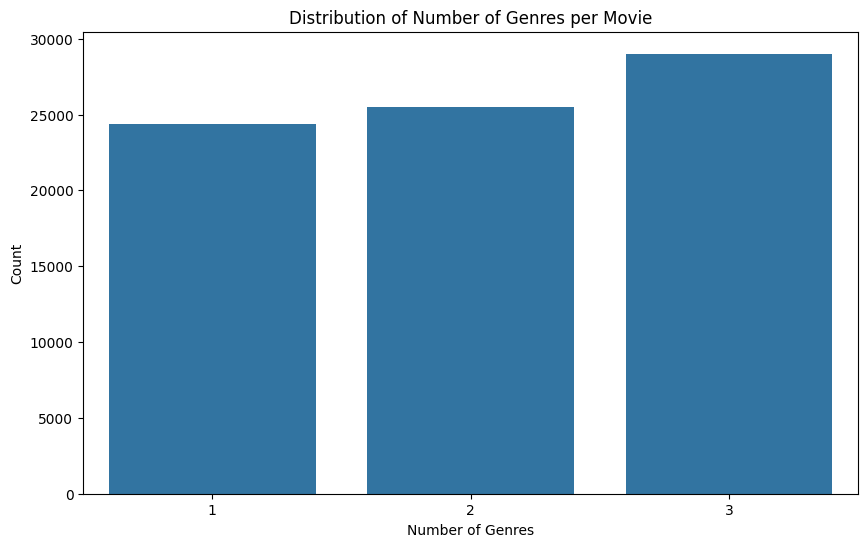

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the number of genres per movie
imdb_movies_data['num_genres'] = imdb_movies_data['genre'].apply(len)

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=imdb_movies_data)
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yarden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yarden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


count    78843.000000
mean       159.879025
std         48.711892
min          2.000000
25%        124.000000
50%        180.000000
75%        192.000000
max        402.000000
Name: description_length, dtype: float64


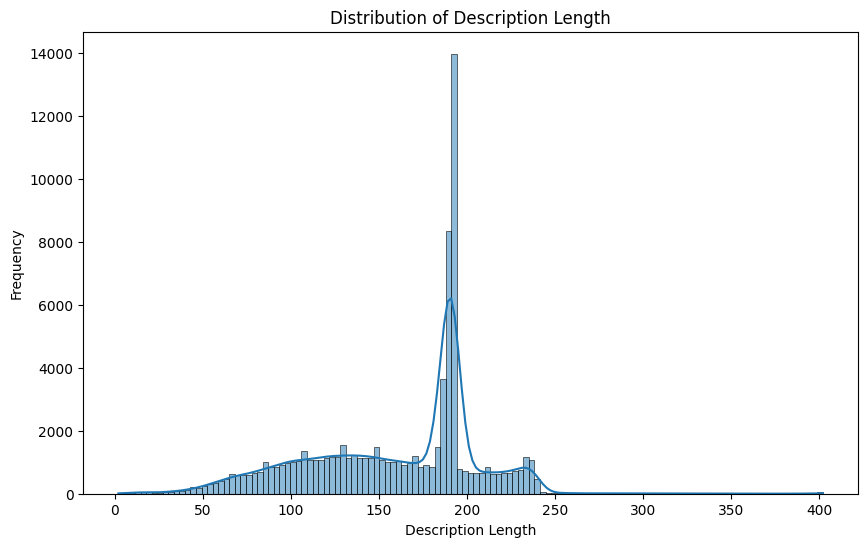

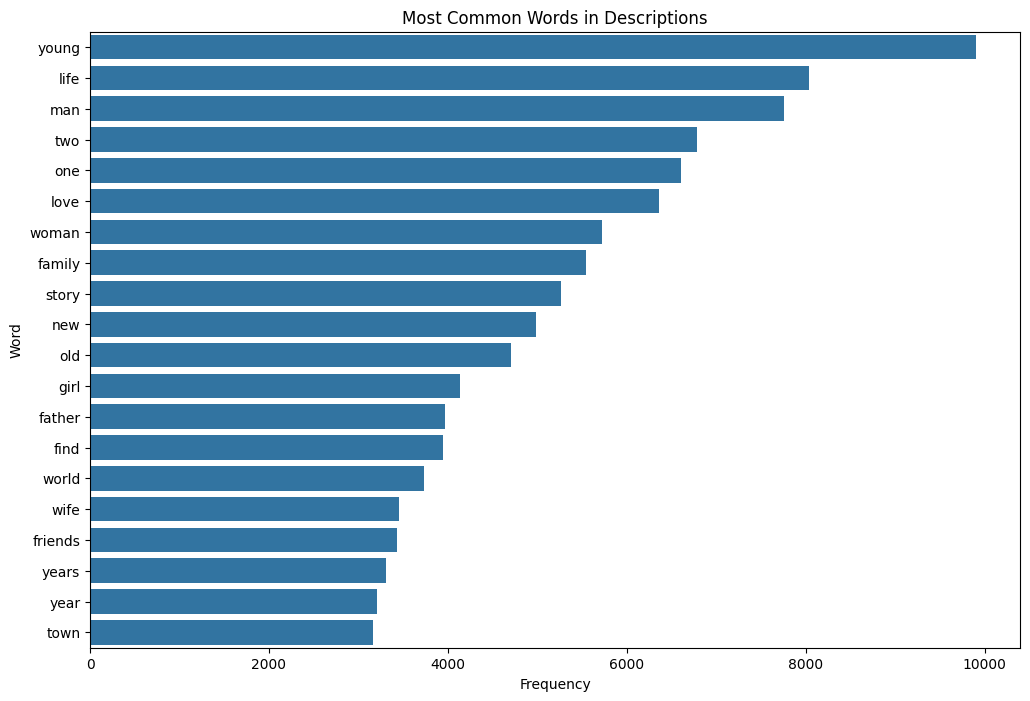

In [24]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load stop words
stop_words = set(stopwords.words('english'))

# Basic statistics of the 'description' length
imdb_movies_data['description_length'] = imdb_movies_data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)
print(imdb_movies_data['description_length'].describe())

# Visualize the distribution of description lengths
plt.figure(figsize=(10, 6))
sns.histplot(imdb_movies_data['description_length'], kde=True)
plt.title('Distribution of Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()


# Function to preprocess the description and return word counts
def preprocess_description(description):
    words = re.findall(r'\b\w+\b', description.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return words

# Get all words from descriptions
all_words = []
for desc in imdb_movies_data['description'].dropna():
    all_words.extend(preprocess_description(desc))

word_freq = Counter(all_words)

# Visualize the most common words
most_common_words = word_freq.most_common(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=[item[1] for item in most_common_words], y=[item[0] for item in most_common_words])
plt.title('Most Common Words in Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

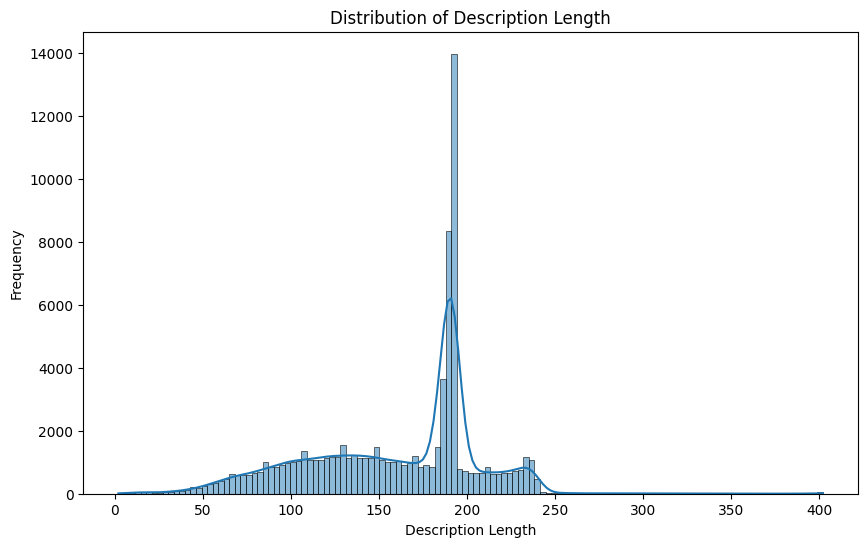

In [25]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plotting the distribution of description lengths
plt.figure(figsize=(10, 6))
sns.histplot(imdb_movies_data['description_length'], kde=True)
plt.title('Distribution of Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

### Active learning pipeline

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Load data
data = imdb_movies_data[['genre', 'description']].dropna()

# Preprocess data
data['description'] = data['description'].apply(lambda x: x.lower())

# Encode labels
mlb = MultiLabelBinarizer()
# data['genre'] = data['genre'].apply(lambda x: x.split(','))
y = mlb.fit_transform(data['genre'])

# Split data
X_train, X_pool, y_train, y_pool = train_test_split(data['description'], y, test_size=0.9, random_state=42)
X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=0.1, random_state=42)

# Initialize vectorizer and model
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Active Learning Loop
n_iterations = 10
batch_size = 32

for iteration in range(n_iterations):
    # Train the model
    model.fit(X_train_vec, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_vec)
    print(f"Iteration {iteration + 1}")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_))

    # Randomly sample from the pool set
    sample_indices = np.random.choice(len(X_pool), size=batch_size, replace=False)
    X_sample = X_pool.iloc[sample_indices]
    y_sample = y_pool[sample_indices]

    # Vectorize the sampled data
    X_sample_vec = vectorizer.transform(X_sample)

    # Add sampled data to the training set
    if hasattr(X_train_vec, 'toarray'):
        X_train_vec = np.vstack([X_train_vec.toarray(), X_sample_vec.toarray()])
    else:
        X_train_vec = np.vstack([X_train_vec, X_sample_vec.toarray()])
        
    y_train = np.vstack([y_train, y_sample])

    # Remove sampled data from the pool set
    X_pool = X_pool.drop(X_pool.index[sample_indices])
    y_pool = np.delete(y_pool, sample_indices, axis=0)

# Evaluate final model
final_preds = model.predict(X_test_vec)
print("Final Model Evaluation")
print(classification_report(y_test, final_preds, target_names=mlb.classes_))

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(


Iteration 1
              precision    recall  f1-score   support

      Action       0.72      0.08      0.14      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.83      0.02      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.29      0.41      2414
       Crime       0.64      0.08      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.77      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.09      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 2
              precision    recall  f1-score   support

      Action       0.74      0.08      0.15      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.83      0.02      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.29      0.41      2414
       Crime       0.64      0.08      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.91      0.10      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 3
              precision    recall  f1-score   support

      Action       0.75      0.08      0.15      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.80      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.30      0.41      2414
       Crime       0.64      0.08      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.91      0.10      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 4
              precision    recall  f1-score   support

      Action       0.76      0.08      0.15      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.80      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.66      0.30      0.41      2414
       Crime       0.64      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.10      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 5
              precision    recall  f1-score   support

      Action       0.77      0.08      0.15      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.80      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.30      0.41      2414
       Crime       0.64      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.10      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 6
              precision    recall  f1-score   support

      Action       0.77      0.08      0.15      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.84      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.30      0.41      2414
       Crime       0.64      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.10      0.18       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 7
              precision    recall  f1-score   support

      Action       0.76      0.09      0.16      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.80      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.30      0.41      2414
       Crime       0.65      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.89      0.10      0.17       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 8
              precision    recall  f1-score   support

      Action       0.75      0.09      0.16      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.82      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.67      0.30      0.41      2414
       Crime       0.65      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.89      0.10      0.18       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 9
              precision    recall  f1-score   support

      Action       0.75      0.09      0.16      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.80      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.66      0.29      0.41      2414
       Crime       0.64      0.08      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.76      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.89      0.10      0.18       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery   

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Iteration 10
              precision    recall  f1-score   support

      Action       0.73      0.09      0.16      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.82      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.66      0.30      0.41      2414
       Crime       0.64      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.77      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.10      0.18       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
     Mystery  

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

Final Model Evaluation
              precision    recall  f1-score   support

      Action       0.73      0.09      0.16      1097
       Adult       0.00      0.00      0.00         0
   Adventure       0.82      0.03      0.05       640
   Animation       0.00      0.00      0.00       179
   Biography       0.75      0.02      0.03       197
      Comedy       0.66      0.30      0.41      2414
       Crime       0.64      0.09      0.15       897
 Documentary       0.00      0.00      0.00         0
       Drama       0.67      0.77      0.71      3847
      Family       0.00      0.00      0.00       324
     Fantasy       0.00      0.00      0.00       329
   Film-Noir       0.00      0.00      0.00        50
   Game-Show       0.00      0.00      0.00         1
     History       0.00      0.00      0.00       189
      Horror       0.90      0.10      0.18       841
       Music       0.00      0.00      0.00       150
     Musical       0.00      0.00      0.00       180
    

c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yarden\AppData\Local\pypoetry\Cache\virtualenvs\dataanalysisvisualizationfiles-2DKRXcGy-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined 

In [ ]:
# Active Learning Loop
n_iterations = 10
batch_size = 32

for iteration in range(n_iterations):
    # Train the model
    model.fit(X_train_vec, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_vec)
    print(f"Iteration {iteration + 1}")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_))

    # Randomly sample from the pool set
    sample_indices = np.random.choice(len(X_pool), size=batch_size, replace=False)
    X_sample = X_pool.iloc[sample_indices]
    y_sample = y_pool[sample_indices]

    # Vectorize the sampled data
    X_sample_vec = vectorizer.transform(X_sample)

    # Add sampled data to the training set
    X_train_vec = np.vstack([X_train_vec.toarray(), X_sample_vec.toarray()])
    y_train = np.vstack([y_train, y_sample])

    # Remove sampled data from the pool set
    X_pool = X_pool.drop(X_pool.index[sample_indices])
    y_pool = np.delete(y_pool, sample_indices, axis=0)

# Evaluate final model
final_preds = model.predict(X_test_vec)
print("Final Model Evaluation")
print(classification_report(y_test, final_preds, target_names=mlb.classes_))

## Skin Cancer ISIC Dataset

the dataset can be found here: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

### First Analysis

Number of Class 0 (not cancer) Images: 1234
Number of Class 1 (cancer) Images: 651


C:\Users\Yarden\AppData\Local\Temp\ipykernel_8856\2481068947.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Class 0 (not cancer)', 'Class 1 (cancer)'], y=[not_cancer, cancer], palette='viridis')


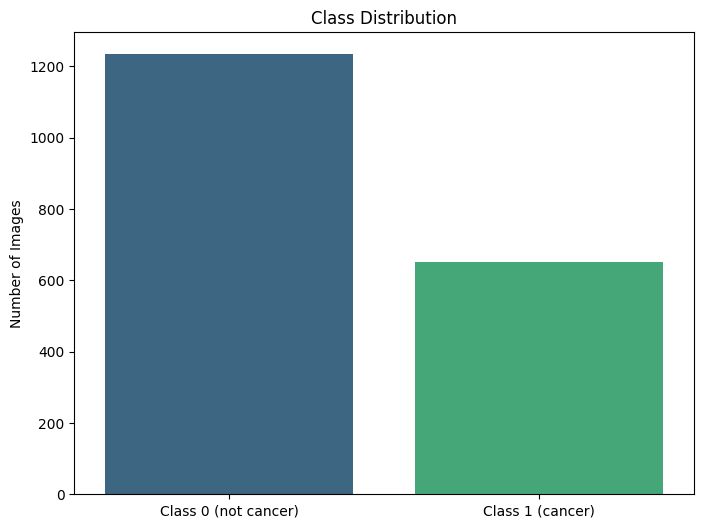

In [33]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the dataset path (assumed to be downloaded and extracted locally)
skin_cancer_dataset_path = '../data/Skin cancer ISIC'

# Function to get the classes and the number of images in each class
def get_class_distribution(dataset_path):
    not_cancer = 0
    cancer = 0
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                if any(keyword in subdir for keyword in ['actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'vascular lesion']):
                    not_cancer += 1
                elif any(keyword in subdir for keyword in ['Basal Cell Carcinoma', 'melanoma', 'squamous cell carcinoma']):
                    cancer += 1
    return not_cancer, cancer

not_cancer, cancer = get_class_distribution(skin_cancer_dataset_path)
print(f"Number of Class 0 (not cancer) Images: {not_cancer}")
print(f"Number of Class 1 (cancer) Images: {cancer}")

# Visualizing the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=['Class 0 (not cancer)', 'Class 1 (cancer)'], y=[not_cancer, cancer], palette='viridis')
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

In [35]:
# Function to load and display some sample images
def load_and_display_sample_images(dataset_path, num_samples=5):
    sample_images = []
    sample_labels = []
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img = Image.open(os.path.join(subdir, file))
                if any(keyword in subdir for keyword in ['actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'vascular lesion']):
                    label = 'not cancer'
                elif any(keyword in subdir for keyword in ['Basal Cell Carcinoma', 'melanoma', 'squamous cell carcinoma']):
                    label = 'cancer'
                sample_images.append(img)
                sample_labels.append(label)
                if len(sample_images) >= num_samples:
                    break
        if len(sample_images) >= num_samples:
            break

    # Displaying the images
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_images[i])
        plt.title(sample_labels[i])
        plt.axis('off')
    plt.show()

# Load and display sample images
# load_and_display_sample_images(skin_cancer_dataset_path, num_samples=5)

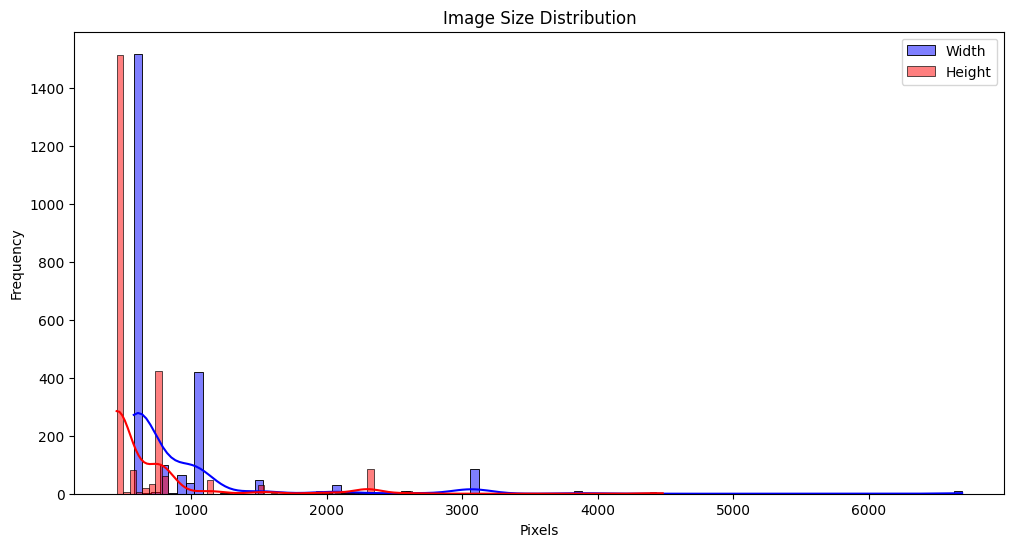

In [37]:
# Function to get the distribution of image sizes
def get_image_size_distribution(dataset_path):
    widths = []
    heights = []
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img = Image.open(os.path.join(subdir, file))
                widths.append(img.width)
                heights.append(img.height)

    return widths, heights

widths, heights = get_image_size_distribution(skin_cancer_dataset_path)

# Visualize the distribution of image sizes
plt.figure(figsize=(12, 6))
sns.histplot(widths, kde=True, color='blue', label='Width')
sns.histplot(heights, kde=True, color='red', label='Height')
plt.title('Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

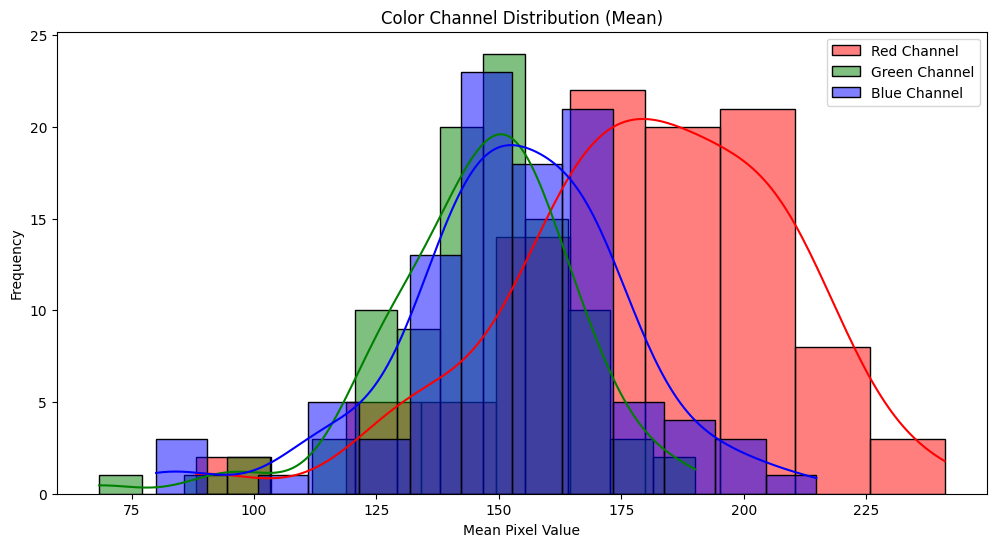

In [39]:
# Function to analyze the color distribution
def get_color_distribution(dataset_path, num_samples=100):
    red_channel = []
    green_channel = []
    blue_channel = []

    sample_count = 0
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img = Image.open(os.path.join(subdir, file))
                img_array = np.array(img)
                red_channel.append(np.mean(img_array[:, :, 0]))
                green_channel.append(np.mean(img_array[:, :, 1]))
                blue_channel.append(np.mean(img_array[:, :, 2]))

                sample_count += 1
                if sample_count >= num_samples:
                    break
        if sample_count >= num_samples:
            break

    return red_channel, green_channel, blue_channel

red_channel, green_channel, blue_channel = get_color_distribution(skin_cancer_dataset_path)

# Visualize the color distribution
plt.figure(figsize=(12, 6))
sns.histplot(red_channel, kde=True, color='red', label='Red Channel')
sns.histplot(green_channel, kde=True, color='green', label='Green Channel')
sns.histplot(blue_channel, kde=True, color='blue', label='Blue Channel')
plt.title('Color Channel Distribution (Mean)')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Active learning pipeline

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to load the images and labels
def load_images_and_labels(dataset_path, img_size=(50, 50)):
    images = []
    labels = []
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
                label = 1 if 'class1' in subdir else 0
                labels.append(label)
    return np.array(images), np.array(labels)

# Load the images and labels
images, labels = load_images_and_labels(skin_cancer_dataset_path)

# Split data into a pool of unlabeled data and a small initial training set
X_pool, X_initial, y_pool, y_initial = train_test_split(images, labels, test_size=0.05, random_state=42)

# Normalize the images
X_pool = X_pool / 255.0
X_initial = X_initial / 255.0

# Define a simple CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
input_shape = (50, 50, 3)
model = create_cnn_model(input_shape)

# Train the model on the initial training set
model.fit(X_initial, y_initial, epochs=5, batch_size=32, validation_split=0.2)

# Define the number of iterations and the sample size for each iteration
iterations = 10
sample_size = 100

# Active Learning Loop
for i in range(iterations):
    # Randomly sample a subset from the pool
    sample_indices = random.sample(range(len(X_pool)), sample_size)
    X_sampled = X_pool[sample_indices]
    y_sampled = y_pool[sample_indices]

    # Update the training data
    X_initial = np.vstack((X_initial, X_sampled))
    y_initial = np.hstack((y_initial, y_sampled))

    # Retrain the model on the updated training set
    model.fit(X_initial, y_initial, epochs=5, batch_size=32, validation_split=0.2)

    # Evaluate the model on the remaining pool
    y_pred = model.predict(X_pool).round()
    accuracy = accuracy_score(y_pool, y_pred)
    print(f"Iteration {i+1}/{iterations} - Accuracy: {accuracy:.4f}")

    # Remove the sampled instances from the pool
    X_pool = np.delete(X_pool, sample_indices, axis=0)
    y_pool = np.delete(y_pool, sample_indices, axis=0)

    # Check if the pool is empty
    if len(X_pool) == 0:
        print("No more data to sample from.")
        break